# Random Forests

- use scikit-learn for **random forests**
- do **ordinal encoding** with high-cardinality categoricals
- understand how categorical encodings affect trees differently compared to linear models
- understand how tree ensembles reduce overfitting compared to a single decision tree with unlimited depth

Today's lesson has two take-away messages:

#### Try Tree Ensembles when you do machine learning with labeled, tabular data
- "Tree Ensembles" means Random Forest or Gradient Boosting models. 
- [Tree Ensembles often have the best predictive accuracy](https://arxiv.org/abs/1708.05070) with labeled, tabular data.
- Why? Because trees can fit non-linear, non-[monotonic](https://en.wikipedia.org/wiki/Monotonic_function) relationships, and [interactions](https://christophm.github.io/interpretable-ml-book/interaction.html) between features.
- A single decision tree, grown to unlimited depth, will [overfit](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/). We solve this problem by ensembling trees, with bagging (Random Forest) or boosting (Gradient Boosting).
- Random Forest's advantage: may be less sensitive to hyperparameters. Gradient Boosting's advantage: may get better predictive accuracy.

#### One-hot encoding isn’t the only way, and may not be the best way, of categorical encoding for tree ensembles.
- For example, tree ensembles can work with arbitrary "ordinal" encoding! (Randomly assigning an integer to each category.) Compared to one-hot encoding, the dimensionality will be lower, and the predictive accuracy may be just as good or even better.



<img src="https://github.com/austinlasseter/DS-Unit-2-Kaggle-Challenge/blob/master/module2-random-forests/random_forest.png?raw=1" alt="random forest" width="500"/>

# Use scikit-learn for random forests

### Solution example

First, read & wrangle the data.

> Define a function to wrangle train, validate, and test sets in the same way. Clean outliers and engineer features. (For example, [what other columns have zeros and shouldn't?](https://github.com/Quartz/bad-data-guide#zeros-replace-missing-values) What other columns are duplicates, or nearly duplicates? Can you extract the year from date_recorded? Can you engineer new features, such as the number of years from waterpump construction to waterpump inspection?)

Check out the [Tanzania Waterpumps Kaggle Challenge](https://www.kaggle.com/danielmartinalarcon/tanzanian-water-pumps):

> Using data from Taarifa and the Tanzanian Ministry of Water, can you predict which pumps are functional, which need some repairs, and which don't work at all? Predict one of these three classes based on a number of variables about what kind of pump is operating, when it was installed, and how it is managed. A smart understanding of which waterpoints will fail can improve maintenance operations and ensure that clean, potable water is available to communities across Tanzania.


The Tanzania Waterpumps data has outliers and missing values. Let's start to clean it.

First, load & split data.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

train = pd.merge(pd.read_csv('../data/waterpumps/train_features.csv'), 
                 pd.read_csv('../data/waterpumps/train_labels.csv'))
test = pd.read_csv('../data/waterpumps/test_features.csv')
sample_submission = pd.read_csv('../data/waterpumps/sample_submission.csv')

# Split train into train & val
train, val = train_test_split(train, train_size=0.80, test_size=0.20, 
                              stratify=train['status_group'], random_state=42)

train.shape, val.shape, test.shape

((47520, 41), (11880, 41), (14358, 40))

In [2]:
import numpy as np

def wrangle(X):
    """Wrangle train, validate, and test sets in the same way"""
    
    # Prevent SettingWithCopyWarning
    X = X.copy()
    
    # About 3% of the time, latitude has small values near zero,
    # outside Tanzania, so we'll treat these values like zero.
    X['latitude'] = X['latitude'].replace(-2e-08, 0)
    
    # When columns have zeros and shouldn't, they are like null values.
    # So we will replace the zeros with nulls, and impute missing values later.
    cols_with_zeros = ['longitude', 'latitude']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
            
    # quantity & quantity_group are duplicates, so drop one
    X = X.drop(columns='quantity_group')
    
    # return the wrangled dataframe
    return X


train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

In [3]:
# The status_group column is the target
target = 'status_group'

# Get a dataframe with all train columns except the target
train_features = train.drop(columns=[target])

# Get a list of the numeric features
numeric_features = train_features.select_dtypes(include='number').columns.tolist()

# Get a series with the cardinality of the nonnumeric features
cardinality = train_features.select_dtypes(exclude='number').nunique()

# Get a list of all categorical features with cardinality <= 50
categorical_features = cardinality[cardinality <= 50].index.tolist()

# Combine the lists 
features = numeric_features + categorical_features

In [4]:
# Arrange data into X features matrix and y target vector 
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

In [5]:
train.describe(exclude='number').T.unique.sum()

56826

## Follow Along

[Scikit-Learn User Guide: Random Forests](https://scikit-learn.org/stable/modules/ensemble.html#random-forests)

In [6]:
# let's take a small sample for comparison purposes
region = X_train[['region']].copy()
region = region.sample(30)
region.head()

,region
50380,Iringa
2068,Mwanza
6946,Morogoro
44553,Dodoma
6652,Shinyanga


In [7]:
# how many regions are there?
region['region'].value_counts()

Mwanza           4
Arusha           3
Kilimanjaro      3
Mbeya            3
Morogoro         3
Pwani            2
Ruvuma           2
Iringa           2
Kagera           2
Kigoma           1
Manyara          1
Tabora           1
Dar es Salaam    1
Shinyanga        1
Dodoma           1
Name: region, dtype: int64

In [8]:
# what does one-hot encoding look like?
region_ohe=pd.get_dummies(region['region'], prefix='region')
region_ohe.head().T.sort_index()

,50380,2068,6946,44553,6652
region_Arusha,0,0,0,0,0
region_Dar es Salaam,0,0,0,0,0
region_Dodoma,0,0,0,1,0
region_Iringa,1,0,0,0,0
region_Kagera,0,0,0,0,0
region_Kigoma,0,0,0,0,0
region_Kilimanjaro,0,0,0,0,0
region_Manyara,0,0,0,0,0
region_Mbeya,0,0,0,0,0
region_Morogoro,0,0,1,0,0


In [9]:
# exactly the same thing, but with scikit learn
import category_encoders as ce
encoder = ce.OneHotEncoder(use_cat_names=True)
region_ohe2 = encoder.fit_transform(region['region'])
region_ohe2.head().T.sort_index()

/usr/local/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


,50380,2068,6946,44553,6652
region_Arusha,0,0,0,0,0
region_Dar es Salaam,0,0,0,0,0
region_Dodoma,0,0,0,1,0
region_Iringa,1,0,0,0,0
region_Kagera,0,0,0,0,0
region_Kigoma,0,0,0,0,0
region_Kilimanjaro,0,0,0,0,0
region_Manyara,0,0,0,0,0
region_Mbeya,0,0,0,0,0
region_Morogoro,0,0,1,0,0


### Put that into a pipeline.

In [10]:
%%time
# WARNING: the %%time command sometimes has quirks/bugs

import category_encoders as ce
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(random_state=0, n_jobs=-1)
)

# Fit on train, score on val
pipeline.fit(X_train, y_train)
print('Validation Accuracy', pipeline.score(X_val, y_val))

/usr/local/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Validation Accuracy 0.8031986531986532
CPU times: user 20.9 s, sys: 2.55 s, total: 23.5 s
Wall time: 13.6 s


In [11]:
print('X_train shape before encoding', X_train.shape)

X_train shape before encoding (47520, 31)


In [12]:
encoder = pipeline.named_steps['onehotencoder']
encoded = encoder.transform(X_train)
print('X_train shape after encoding', encoded.shape)

X_train shape after encoding (47520, 181)


In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

# Get feature importances
rf = pipeline.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, encoded.columns)
importances.sort_values(ascending=False).head(15)


latitude                       0.108899
longitude                      0.107356
id                             0.092928
quantity_dry                   0.067177
gps_height                     0.055907
construction_year              0.045861
population                     0.040339
quantity_enough                0.024037
district_code                  0.022009
waterpoint_type_other          0.020272
amount_tsh                     0.018474
extraction_type_other          0.015214
region_code                    0.015054
waterpoint_type_group_other    0.013051
quantity_insufficient          0.012924
dtype: float64

In [14]:
importances.sort_values(ascending=False).head(20).index

Index(['latitude', 'longitude', 'id', 'quantity_dry', 'gps_height',
       'construction_year', 'population', 'quantity_enough', 'district_code',
       'waterpoint_type_other', 'amount_tsh', 'extraction_type_other',
       'region_code', 'waterpoint_type_group_other', 'quantity_insufficient',
       'extraction_type_class_other', 'extraction_type_group_other',
       'waterpoint_type_communal standpipe multiple', 'payment_type_never pay',
       'waterpoint_type_communal standpipe'],
      dtype='object')

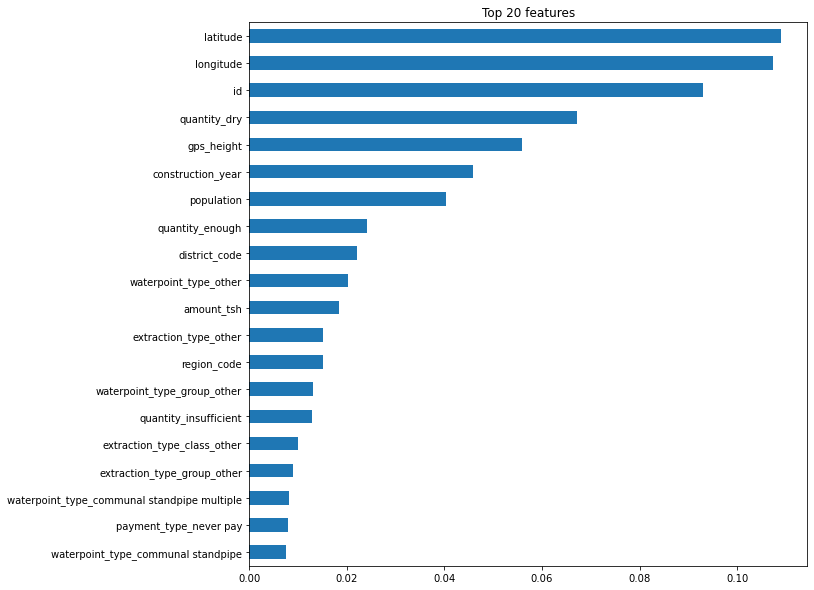

In [15]:
# Plot top n feature importances
n = 20
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh();

# Do ordinal encoding with high-cardinality categoricals

## Overview

http://contrib.scikit-learn.org/categorical-encoding/ordinal.html

## Follow Along

In [16]:
# Re-arrange data into X features matrix and y target vector, so
# we use *all* features, including the high-cardinality categoricals
X_train = train.drop(columns=target)
y_train = train[target]
X_val = val.drop(columns=target)
y_val = val[target]
X_test = test

### There's a couple of ways to encode categorical variables

In [17]:
# let's take a small sample for comparison purposes
region = X_train[['region']].copy()
region = region.sample(30)
region.head()

,region
24044,Mara
36687,Shinyanga
28089,Mwanza
12835,Morogoro
48074,Tanga


In [18]:
# Method 1
# Encode the categorical columns using the pandas "category" data type
region['region_cats']=region['region'].astype('category')
region['region_codes']= region['region_cats'].cat.codes
region.dtypes

region            object
region_cats     category
region_codes        int8
dtype: object

In [19]:
# show a few
region.head()

,region,region_cats,region_codes
24044,Mara,Mara,6
36687,Shinyanga,Shinyanga,13
28089,Mwanza,Mwanza,10
12835,Morogoro,Morogoro,8
48074,Tanga,Tanga,15


In [20]:
# distribution (note that the values start at 0)
region['region_codes'].value_counts().sort_index()

0     2
1     2
2     4
3     2
4     1
5     1
6     1
7     1
8     5
9     1
10    2
11    2
12    1
13    2
14    2
15    1
Name: region_codes, dtype: int64

In [21]:
# Method 2
# Encode the categorical columns using scikit learn's ordinal encoding class
myencoder=ce.OrdinalEncoder()
region['region_encoded'] = myencoder.fit_transform(region['region'])
region.sample(5)

,region,region_cats,region_codes,region_encoded
6755,Pwani,Pwani,11,8
42476,Mbeya,Mbeya,7,13
32420,Kilimanjaro,Kilimanjaro,5,16
12862,Pwani,Pwani,11,8
12835,Morogoro,Morogoro,8,4


In [22]:
# they are the same distribution but starting at 1 not 0
region['region_encoded'].value_counts().sort_index()

1     1
2     2
3     2
4     5
5     1
6     2
7     4
8     2
9     2
10    1
11    2
12    2
13    1
14    1
15    1
16    1
Name: region_encoded, dtype: int64

### Okay back to our scheduled programming

In [23]:
%%time

# This pipeline is identical to the example cell above, 
# except we're replacing one-hot encoder with "ordinal" encoder

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(random_state=0, n_jobs=-1)
)

# Fit on train, score on val
pipeline.fit(X_train, y_train)
print('Validation Accuracy', pipeline.score(X_val, y_val))

Validation Accuracy 0.8114478114478114
CPU times: user 17.5 s, sys: 380 ms, total: 17.9 s
Wall time: 6.81 s


In [24]:
print('X_train shape before encoding', X_train.shape)

X_train shape before encoding (47520, 39)


In [25]:
encoder = pipeline.named_steps['ordinalencoder']
encoded = encoder.transform(X_train)
print('X_train shape after encoding', encoded.shape)

X_train shape after encoding (47520, 39)


# Understand how categorical encodings affect trees differently compared to linear models

### Categorical exploration, 1 feature at a time

Change `feature`, then re-run these cells!

In [26]:
feature = 'extraction_type_class'

In [27]:
X_train[feature].value_counts()

gravity         21448
handpump        13184
other            5193
submersible      4894
motorpump        2355
rope pump         353
wind-powered       93
Name: extraction_type_class, dtype: int64

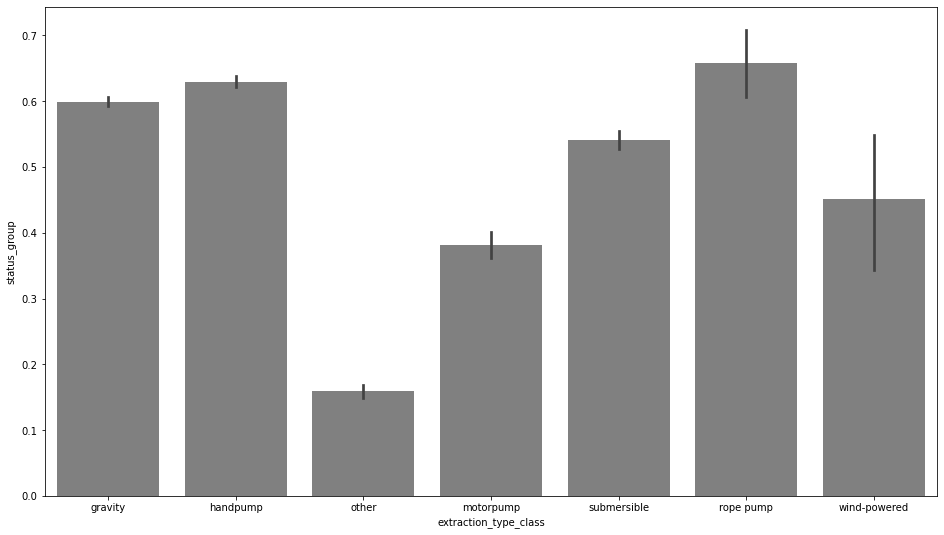

In [28]:
import seaborn as sns
plt.figure(figsize=(16,9))
sns.barplot(
    x=train[feature], 
    y=train['status_group']=='functional', 
    color='grey'
);

In [29]:
X_train[feature].head(20)

43360        gravity
7263         gravity
2486        handpump
313            other
52726      motorpump
8558         gravity
2559         gravity
54735      motorpump
25763       handpump
44540    submersible
28603          other
4372     submersible
30666        gravity
6431     submersible
57420          other
1373         gravity
2026         gravity
58977       handpump
41101        gravity
10019        gravity
Name: extraction_type_class, dtype: object

### [One Hot Encoding](http://contrib.scikit-learn.org/categorical-encoding/onehot.html)

> Onehot (or dummy) coding for categorical features, produces one feature per category, each binary.

Warning: May run slow, or run out of memory, with high cardinality categoricals!

In [30]:
encoder = ce.OneHotEncoder(use_cat_names=True)
encoded = encoder.fit_transform(X_train[[feature]])
print(f'{len(encoded.columns)} columns')
encoded.head(20)

7 columns


/usr/local/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


,extraction_type_class_gravity,extraction_type_class_handpump,extraction_type_class_other,extraction_type_class_motorpump,extraction_type_class_submersible,extraction_type_class_rope pump,extraction_type_class_wind-powered
43360,1,0,0,0,0,0,0
7263,1,0,0,0,0,0,0
2486,0,1,0,0,0,0,0
313,0,0,1,0,0,0,0
52726,0,0,0,1,0,0,0
8558,1,0,0,0,0,0,0
2559,1,0,0,0,0,0,0
54735,0,0,0,1,0,0,0
25763,0,1,0,0,0,0,0
44540,0,0,0,0,1,0,0


#### One-Hot Encoding, Logistic Regression, Validation Accuracy

In [31]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler

lr = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True), 
    SimpleImputer(), 
    StandardScaler(), 
    LogisticRegressionCV(multi_class='auto', solver='lbfgs', cv=5, n_jobs=-1)
)

lr.fit(X_train[[feature]], y_train)
score = lr.score(X_val[[feature]], y_val)
print('Logistic Regression, Validation Accuracy', score)

/usr/local/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Logistic Regression, Validation Accuracy 0.6202861952861953


#### One-Hot Encoding, Decision Tree, Validation Accuracy

In [32]:
from sklearn.tree import DecisionTreeClassifier

dt = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True), 
    SimpleImputer(), 
    DecisionTreeClassifier(random_state=42)
)

dt.fit(X_train[[feature]], y_train)
score = dt.score(X_val[[feature]], y_val)
print('Decision Tree, Validation Accuracy', score)

Decision Tree, Validation Accuracy 0.6202861952861953


/usr/local/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


#### One-Hot Encoding, Logistic Regression, Model Interpretation

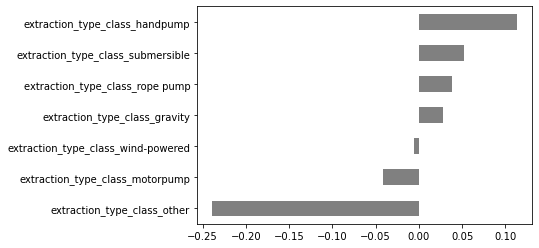

In [33]:
model = lr.named_steps['logisticregressioncv']
encoder = lr.named_steps['onehotencoder']
encoded_columns = encoder.transform(X_val[[feature]]).columns
coefficients = pd.Series(model.coef_[0], encoded_columns)
coefficients.sort_values().plot.barh(color='grey');

#### One-Hot Encoding, Decision Tree, Model Interpretation

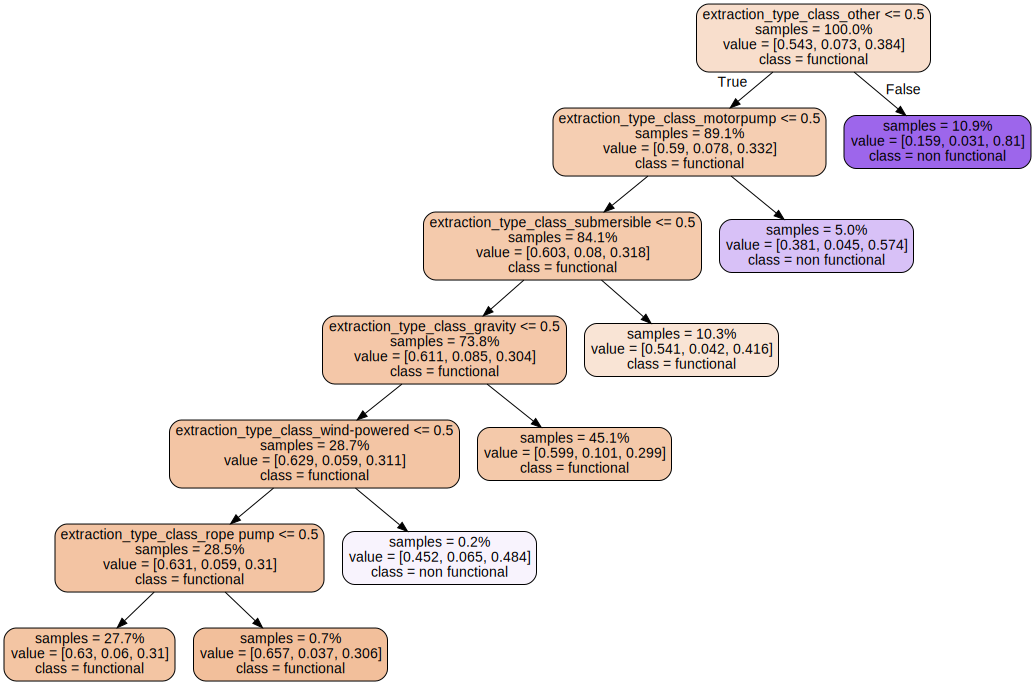

In [34]:
# Plot tree
# https://scikit-learn.org/stable/modules/generated/sklearn.tree.export_graphviz.html
import graphviz
from sklearn.tree import export_graphviz

model = dt.named_steps['decisiontreeclassifier']
encoder = dt.named_steps['onehotencoder']
encoded_columns = encoder.transform(X_val[[feature]]).columns

dot_data = export_graphviz(model, 
                           out_file=None, 
                           max_depth=7, 
                           feature_names=encoded_columns,
                           class_names=model.classes_, 
                           impurity=False, 
                           filled=True, 
                           proportion=True, 
                           rounded=True)   
display(graphviz.Source(dot_data))

In [35]:
pipeline

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['date_recorded', 'funder', 'installer',
                                      'wpt_name', 'basin', 'subvillage',
                                      'region', 'lga', 'ward', 'public_meeting',
                                      'recorded_by', 'scheme_management',
                                      'scheme_name', 'permit',
                                      'extraction_type',
                                      'extraction_type_group',
                                      'extraction_type_class', 'management',
                                      'management_group', 'payment',
                                      'payment_type', 'water_...
communal standpipe multiple    4
improved spring                5
cattle trough                  6
dam                            7
NaN                           -2
dtype: int64},
                                         {'col': 'waterpoint_type_group',
           

### [Ordinal Encoding](http://contrib.scikit-learn.org/categorical-encoding/ordinal.html)

> Ordinal encoding uses a single column of integers to represent the classes. An optional mapping dict can be passed in; in this case, we use the knowledge that there is some true order to the classes themselves. Otherwise, the classes are assumed to have no true order and integers are selected at random.

In [36]:
# what does the original column look like?
X_train[[feature]].head()

,extraction_type_class
43360,gravity
7263,gravity
2486,handpump
313,other
52726,motorpump


In [37]:
# let's apply ordinal encoding to that column!
encoder = ce.OrdinalEncoder()
encoded = encoder.fit_transform(X_train[[feature]])
print(f'1 column, {encoded[feature].nunique()} unique values')
encoded.head(5)

1 column, 7 unique values


,extraction_type_class
43360,1
7263,1
2486,2
313,3
52726,4


In [38]:
# what are the new values?
encoded['extraction_type_class'].value_counts()

1    21448
2    13184
3     5193
5     4894
4     2355
6      353
7       93
Name: extraction_type_class, dtype: int64

#### Beware! Ordinal encoding works well with Tree Models but will ruin your linear models.

#### Ordinal Encoding, Logistic Regression, Validation Accuracy

In [39]:
lr = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(), 
    StandardScaler(), 
    LogisticRegressionCV(multi_class='auto', solver='lbfgs', cv=5, n_jobs=-1)
)

lr.fit(X_train[[feature]], y_train)
score = lr.score(X_val[[feature]], y_val)
print('Logistic Regression, Validation Accuracy', score)

Logistic Regression, Validation Accuracy 0.5417508417508418


#### Ordinal Encoding, Decision Tree, Validation Accuracy

In [40]:
dt = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(), 
    DecisionTreeClassifier(random_state=42)
)

dt.fit(X_train[[feature]], y_train)
score = dt.score(X_val[[feature]], y_val)
print('Decision Tree, Validation Accuracy', score)

Decision Tree, Validation Accuracy 0.6202861952861953


#### Ordinal Encoding, Logistic Regression, Model Interpretation

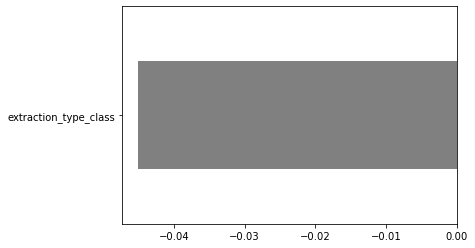

In [41]:
model = lr.named_steps['logisticregressioncv']
encoder = lr.named_steps['ordinalencoder']
encoded_columns = encoder.transform(X_val[[feature]]).columns
coefficients = pd.Series(model.coef_[0], encoded_columns)
coefficients.sort_values().plot.barh(color='grey');

#### Ordinal Encoding, Decision Tree, Model Interpretation

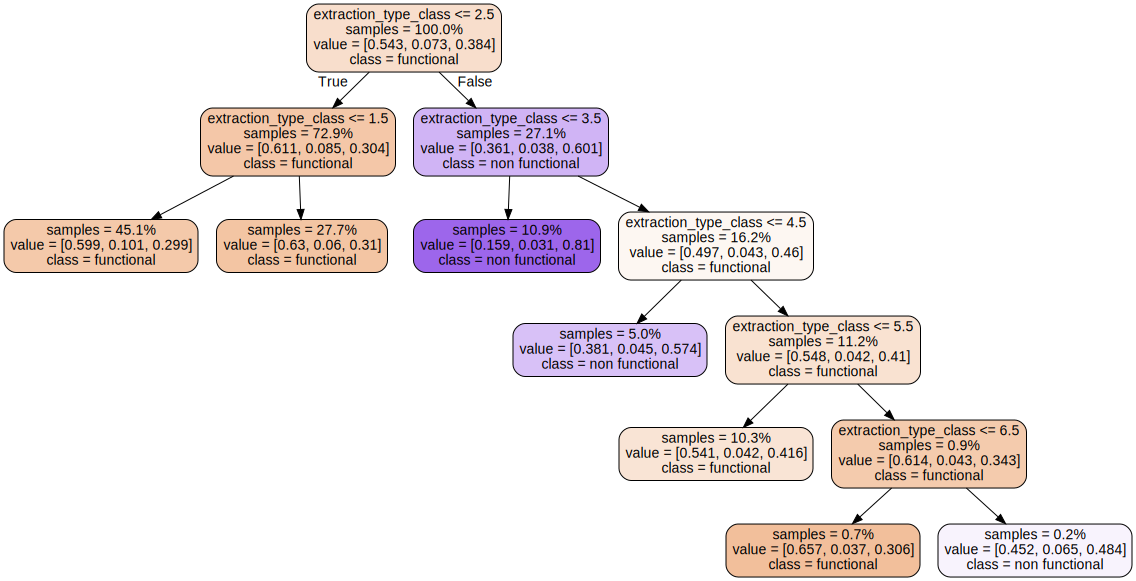

In [42]:
model = dt.named_steps['decisiontreeclassifier']
encoder = dt.named_steps['ordinalencoder']
encoded_columns = encoder.transform(X_val[[feature]]).columns

dot_data = export_graphviz(model, 
                           out_file=None, 
                           max_depth=5, 
                           feature_names=encoded_columns,
                           class_names=model.classes_, 
                           impurity=False, 
                           filled=True, 
                           proportion=True, 
                           rounded=True)   
display(graphviz.Source(dot_data))

### What's "random" about random forests?
1. Each tree trains on a random bootstrap sample of the data. (In scikit-learn, for `RandomForestRegressor` and `RandomForestClassifier`, the `bootstrap` parameter's default is `True`.) This type of ensembling is called Bagging. (Bootstrap AGGregatING.)
2. Each split considers a random subset of the features. (In scikit-learn, when the `max_features` parameter is not `None`.) 

For extra randomness, you can try ["extremely randomized trees"](https://scikit-learn.org/stable/modules/ensemble.html#extremely-randomized-trees)!

>In extremely randomized trees (see [ExtraTreesClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html) and [ExtraTreesRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesRegressor.html) classes), randomness goes one step further in the way splits are computed. As in random forests, a random subset of candidate features is used, but instead of looking for the most discriminative thresholds, thresholds are drawn at random for each candidate feature and the best of these randomly-generated thresholds is picked as the splitting rule. This usually allows to reduce the variance of the model a bit more, at the expense of a slightly greater increase in bias

![](../assets/bagging_boosting.png)

#### Helper function to visualize predicted probabilities



# Review

#### Try Tree Ensembles when you do machine learning with labeled, tabular data
- "Tree Ensembles" means Random Forest or Gradient Boosting models. 
- [Tree Ensembles often have the best predictive accuracy](https://arxiv.org/abs/1708.05070) with labeled, tabular data.
- Why? Because trees can fit non-linear, non-[monotonic](https://en.wikipedia.org/wiki/Monotonic_function) relationships, and [interactions](https://christophm.github.io/interpretable-ml-book/interaction.html) between features.
- A single decision tree, grown to unlimited depth, will [overfit](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/). We solve this problem by ensembling trees, with bagging (Random Forest) or boosting (Gradient Boosting).
- Random Forest's advantage: may be less sensitive to hyperparameters. Gradient Boosting's advantage: may get better predictive accuracy.

#### One-hot encoding isn’t the only way, and may not be the best way, of categorical encoding for tree ensembles.
- For example, tree ensembles can work with arbitrary "ordinal" encoding! (Randomly assigning an integer to each category.) Compared to one-hot encoding, the dimensionality will be lower, and the predictive accuracy may be just as good or even better.
